# Reconstructing even more features with PyGPlates

In this example, we will reconstruct data from the [Paleobiology Database (PBDB)](https://paleobiodb.org/#/).

Import modules

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pygplates
from shapely.geometry.polygon import Polygon, LinearRing, Point
# import scipy
import geopandas as gpd
# import shapely

## Download and import PBDB data

We can import data from the PBDB using the data url straight into [`pandas`](https://pandas.pydata.org/docs/reference/index.html#api). For the following file, it takes about ~8 mins. Alternatively, we can download the csv file from their [website](https://paleobiodb.org/classic/displayDownloadGenerator) and import that.


It is easier if we exclude the metadata at the beginning of the file (an option on the download page), otherwise we need to know how long the header is so that we skip it when we import it.

In [36]:
# download data for the Cenozoic, and inclue the paleoenvironment column.
# You can use the download page to play with the options and get the download link and/or CSV.

pbdb_data_url = 'https://paleobiodb.org/data1.2/occs/list.csv?max_ma=66&min_ma=0&show=coords,env'

In [37]:
%%time
# ^ this is some cell magic! In this case, it will print out the cell execution time 

## import from the URL
# pbdb_data = pd.read_csv(pbdb_data_url, sep=',') 

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 1.91 µs


In [38]:
# import from the csv. This version has a number of columns deleted to make it <50 Mb (original file is 105 Mb)

pbdb_data = pd.read_csv('data/pbdb_data.csv', sep=',')

In [39]:
pbdb_data

,occurrence_no,accepted_name,early_interval,late_interval,max_ma,min_ma,reference_no,lng,lat,environment
0,4451,Brabovus nanincisus,Pliocene,NaN,5.333,2.588,4451,35.130001,-3.130000,eolian indet.
1,14494,Nucula (Nucula) sphenopsis,Lutetian,Priabonian,47.800,33.900,39,-90.405556,32.855000,offshore
2,14495,Nucula (Nucula) smithvillensis,Lutetian,Priabonian,47.800,33.900,39,-90.405556,32.855000,offshore
3,14496,Hilgardia multilineata,Lutetian,Priabonian,47.800,33.900,39,-90.405556,32.855000,offshore
4,14497,Calorhadia (Litorhadia) mater,Lutetian,Priabonian,47.800,33.900,11845,-90.405556,32.855000,offshore
...,...,...,...,...,...,...,...,...,...,...
521623,1592487,Colubriformes,Langhian,NaN,15.970,13.820,81502,8.617388,47.253071,terrestrial indet.
521624,1592497,Lamprophiinae,Late Oligocene,NaN,28.400,23.030,81505,33.200001,-8.933333,fluvial indet.
521625,1592500,Calappa laraensis,Late Oligocene,Early Miocene,28.400,15.970,81510,-69.948608,10.583056,marine indet.
521626,1592501,Raninoides rathbunae,Late Eocene,NaN,37.200,33.900,81510,-69.833336,11.000000,marine indet.


We can easily check the columns of our data

In [40]:
pbdb_data.columns

Index(['occurrence_no', 'accepted_name', 'early_interval', 'late_interval',
       'max_ma', 'min_ma', 'reference_no', 'lng', 'lat', 'environment'],
      dtype='object')

For this example, we've also downloaded the fossil's environment. We can also check the unique environments in the pandas dataframe.

In [41]:
pbdb_data.environment.unique()

array(['eolian indet.', 'offshore', 'interdistributary bay',
       'marine indet.', 'coastal indet.', 'shallow subtidal indet.',
       'open shallow subtidal', 'transition zone/lower shoreface',
       'carbonate indet.', 'deep subtidal ramp', 'offshore ramp', nan,
       'prodelta', 'delta front', 'peritidal',
       'lagoonal/restricted shallow subtidal', 'foreshore',
       'deep subtidal shelf', 'basinal (carbonate)', 'shoreface',
       'estuary/bay', 'offshore indet.', 'deep subtidal indet.',
       'reef, buildup or bioherm', 'paralic indet.', 'lagoonal',
       'terrestrial indet.', '"floodplain"', 'lacustrine - large',
       '"channel"', 'deep-water indet.', 'wet floodplain',
       'crevasse splay', 'pond', 'fine channel fill', 'fluvial indet.',
       'lacustrine - small', 'lacustrine indet.',
       'fluvial-lacustrine indet.', 'karst indet.', 'mire/swamp',
       'sinkhole', 'fissure fill', 'cave', 'basinal (siliciclastic)',
       'alluvial fan', 'offshore shelf', 'del

Based on the environments, we will separate them into broad 'marine' and 'terrestrial' types.
First we create a definition of what the broad environment type is, and then we create a new column with this information

In [42]:
def broad_environment(row):
    if row['environment'] == 'marine indet.'\
    or row['environment'] == 'carbonate indet.'\
    or row['environment'] == 'peritidal'\
    or row['environment'] == 'shallow subtidal indet.'\
    or row['environment'] == 'open shallow subtidal'\
    or row['environment'] == 'lagoonal/restricted shallow subtidal'\
    or row['environment'] == 'sand shoal'\
    or row['environment'] == 'reef'\
    or row['environment'] == 'buildup or bioherm'\
    or row['environment'] == 'perireef or subreef'\
    or row['environment'] == 'intrashelf/intraplatform reef'\
    or row['environment'] == 'platform/shelf-margin reef'\
    or row['environment'] == 'slope/ramp reef'\
    or row['environment'] == 'basin reef'\
    or row['environment'] == 'deep subtidal ramp'\
    or row['environment'] == 'deep subtidal shelf'\
    or row['environment'] == 'deep subtidal indet.'\
    or row['environment'] == 'offshore ramp'\
    or row['environment'] == 'offshore shelf'\
    or row['environment'] == 'offshore indet.'\
    or row['environment'] == 'slope'\
    or row['environment'] == 'basinal (carbonate)'\
    or row['environment'] == 'basinal (siliceous)'\
    or row['environment'] == 'marginal marine indet.'\
    or row['environment'] == 'paralic indet.'\
    or row['environment'] == 'lagoonal'\
    or row['environment'] == 'coastal indet.'\
    or row['environment'] == 'foreshore'\
    or row['environment'] == 'shoreface'\
    or row['environment'] == 'transition zone/lower shoreface'\
    or row['environment'] == 'offshore'\
    or row['environment'] == 'deltaic indet.'\
    or row['environment'] == 'delta plain'\
    or row['environment'] == 'interdistributary bay'\
    or row['environment'] == 'delta front'\
    or row['environment'] == 'prodelta'\
    or row['environment'] == 'deep-water indet.'\
    or row['environment'] == 'submarine fan'\
    or row['environment'] == 'basinal (siliciclastic)'\
    or row['environment'] == 'estuary/bay':
        val = 'marine'
    elif row['environment'] == 'terrestrial indet.'\
    or row['environment'] == 'fluvial-lacustrine indet.'\
    or row['environment'] == 'fluvial indet.'\
    or row['environment'] == 'channel'\
    or row['environment'] == 'channel lag'\
    or row['environment'] == 'coarse channel fill'\
    or row['environment'] == 'fine channel fill'\
    or row['environment'] == 'floodplain'\
    or row['environment'] == 'wet floodplain'\
    or row['environment'] == 'dry floodplain'\
    or row['environment'] == 'levee'\
    or row['environment'] == 'crevasse splay'\
    or row['environment'] == 'lacustrine indet.'\
    or row['environment'] == 'lacustrine - large'\
    or row['environment'] == 'lacustrine - small'\
    or row['environment'] == 'pond'\
    or row['environment'] == 'crater lake'\
    or row['environment'] == 'karst indet.'\
    or row['environment'] == 'fissure fill'\
    or row['environment'] == 'cave'\
    or row['environment'] == 'sinkhole'\
    or row['environment'] == 'eolian indet.'\
    or row['environment'] == 'dune'\
    or row['environment'] == 'interdune'\
    or row['environment'] == 'loess'\
    or row['environment'] == 'fluvial-deltaic indet.'\
    or row['environment'] == 'deltaic indet.'\
    or row['environment'] == 'delta plain'\
    or row['environment'] == 'interdistributary bay'\
    or row['environment'] == 'estuary/bay'\
    or row['environment'] == 'lacustrine deltaic indet.'\
    or row['environment'] == 'lacustrine delta plain'\
    or row['environment'] == 'lacustrine interdistributary bay'\
    or row['environment'] == 'lacustrine delta front'\
    or row['environment'] == 'lacustrine prodelta'\
    or row['environment'] == 'alluvial fan'\
    or row['environment'] == 'mire/swamp'\
    or row['environment'] == 'spring'\
    or row['environment'] == 'tar':
        val = 'terrestrial'
    elif row['environment'] == 'glacial': 
        val = 'glacial'
    elif row['environment'] == np.nan: 
        val = 'not-specified'
    else:
        val = 'skipped'
    return val

In [43]:
# Apply the above defiintion, with the new environment in a column 'environment_broad'

pbdb_data['environment_broad'] = pbdb_data.apply(broad_environment, axis=1)

Now when we print the dataframe, we can see our new column

In [45]:
pbdb_data

,occurrence_no,accepted_name,early_interval,late_interval,max_ma,min_ma,reference_no,lng,lat,environment,environment_broad
0,4451,Brabovus nanincisus,Pliocene,NaN,5.333,2.588,4451,35.130001,-3.130000,eolian indet.,terrestrial
1,14494,Nucula (Nucula) sphenopsis,Lutetian,Priabonian,47.800,33.900,39,-90.405556,32.855000,offshore,marine
2,14495,Nucula (Nucula) smithvillensis,Lutetian,Priabonian,47.800,33.900,39,-90.405556,32.855000,offshore,marine
3,14496,Hilgardia multilineata,Lutetian,Priabonian,47.800,33.900,39,-90.405556,32.855000,offshore,marine
4,14497,Calorhadia (Litorhadia) mater,Lutetian,Priabonian,47.800,33.900,11845,-90.405556,32.855000,offshore,marine
...,...,...,...,...,...,...,...,...,...,...,...
521623,1592487,Colubriformes,Langhian,NaN,15.970,13.820,81502,8.617388,47.253071,terrestrial indet.,terrestrial
521624,1592497,Lamprophiinae,Late Oligocene,NaN,28.400,23.030,81505,33.200001,-8.933333,fluvial indet.,terrestrial
521625,1592500,Calappa laraensis,Late Oligocene,Early Miocene,28.400,15.970,81510,-69.948608,10.583056,marine indet.,marine
521626,1592501,Raninoides rathbunae,Late Eocene,NaN,37.200,33.900,81510,-69.833336,11.000000,marine indet.,marine


---
## Reconstruct PBDB data with PyGPlates

### Import files into PyGPlates

In [46]:
# location of files we want to use
rotation_filename = 'Data/Muller2019-Young2019-Cao2020_CombinedRotations.rot'
static_polygon_file = 'Data/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons.gpmlz'
coastline_filename = 'Data/Global_EarthByte_GPlates_PresentDay_Coastlines.gpmlz'

# read into pygplates
rotation_model = pygplates.RotationModel(rotation_filename)
static_polygons = pygplates.FeatureCollection(static_polygon_file)
coastlines = pygplates.FeatureCollection(coastline_filename)

To reconstruct out PBDB data, which is currently a `pandas` dataframe, we need to convert it into a `pygplates.Feature`.

To do this, we will loop through each row and create a [`pygplates.PointOnSphere`](https://www.gplates.org/docs/pygplates/generated/pygplates.pointonsphere) instance, using the coordinates in our latitude and longitude columns. We then create our `pygplates.Feature`, and assign this pygplates.PointOnSphere instance inside `Feature.set_geometry`.


We can also preserve our favourite columns using [`set_shapefile_attribute`](https://www.gplates.org/docs/pygplates/generated/pygplates.feature#pygplates.Feature.set_shapefile_attribute)

In [47]:
pbdb_data.columns  # check our column names

Index(['occurrence_no', 'accepted_name', 'early_interval', 'late_interval',
       'max_ma', 'min_ma', 'reference_no', 'lng', 'lat', 'environment',
       'environment_broad'],
      dtype='object')

In [107]:
# convert pbdb data to gplates feature
pbdb_point_features = []

for index, row in pbdb_data.iterrows():
    point = pygplates.PointOnSphere(float(row.lat), float(row.lng))  # use the lat and lng columns as our coordinates
    pbdb_point_feature = pygplates.Feature()
    pbdb_point_feature.set_geometry(point)
    pbdb_point_feature.set_shapefile_attribute('accepted_name', row.accepted_name)
    pbdb_point_feature.set_shapefile_attribute('environment', row.environment)
    pbdb_point_feature.set_shapefile_attribute('environment_broad', row.environment_broad)
    pbdb_point_feature.set_shapefile_attribute('early_interval', row.early_interval)
    pbdb_point_feature.set_shapefile_attribute('late_interval', row.late_interval)
    pbdb_point_feature.set_shapefile_attribute('occurrence_no', row.occurrence_no)
    pbdb_point_feature.set_valid_time(row.max_ma, row.min_ma)  # assign ages for each point
    pbdb_point_features.append(pbdb_point_feature)   # save to pbdb_point_features


In [108]:
%%time

# Assign plate IDs to the fossil data so that each point now has a plate ID

# This may take a while (~13 mins)
pbdb_cc = pygplates.partition_into_plates(static_polygons, rotation_model, 
                                          pbdb_point_features,
                                          properties_to_copy = [pygplates.PartitionProperty.reconstruction_plate_id])

CPU times: user 12min 31s, sys: 4.35 s, total: 12min 35s
Wall time: 12min 36s


### Reconstruct points to 30 Ma

Similar to previous examples, we use `pygplates.reconstruct` to reconstruct our points

In [109]:
# reconstruct pbdb data
pbdb_30Ma = []
reconstruction_time = 30
pygplates.reconstruct(pbdb_cc, rotation_model, pbdb_30Ma, reconstruction_time)

### Convert our reconstructed points into a geoDataFrame

Using a GeoDataFrame makes it easier to keep track of all our attributes!

In [132]:
def create_geodataframe_from_pbdb(pygplates_recon_geom, reconstruction_time):
    """ This is a function to convert reconstructed paleobiology database point features
    from pygplates into a GeoDataFrame. Note that here, the input geometry must be a point
    
    Input: 
        - pygplates.ReconstructedFeatureGeometry (i.e., output of pygplates.reconstruct)
        - recontruction time - this is just for safekeeping in the geodataframe!
    Output: 
        - gpd.GeoDataFrame of the feature"""
    
    # create new and empy geodataframe
    recon_gpd = gpd.GeoDataFrame()
    recon_gpd['NAME'] = None
    recon_gpd['PLATEID1'] = None
    recon_gpd['FROMAGE'] = None
    recon_gpd['TOAGE'] = None
    recon_gpd['accepted_names'] = None
    recon_gpd['environment'] = None
    recon_gpd['environment_broad'] = None
    recon_gpd['late_interval'] = None
    recon_gpd['early_inverval'] = None
    recon_gpd['occurrence_no'] = None
    recon_gpd['geometry'] = None
    recon_gpd['reconstruction_time'] = None
    recon_gpd = recon_gpd.set_crs(epsg=4326)
    
    # empty arrays to append to
    fromages             = []
    toages               = []
    plateid1s            = []
    accepted_names       = []
    environments         = []
    broad_environments   = []
    early_intervals      = []
    late_intervals       = []
    occurence_nos        = []
    geometries           = []
    reconstruction_times = []
    
    for i in pygplates_recon_geom:
        point = i.get_feature()
        # contains present-day coordinates
        plat, plon = point.get_geometry().to_lat_lon()
        
        # reconstructed coordinates
        recon_point = i.get_reconstructed_geometry()
        rlat, rlon = recon_point.to_lat_lon()
        
        # get feature attributes
        fromages.append(point.get_valid_time()[0])
        toages.append(point.get_valid_time()[1])
        plateid1s.append(point.get_reconstruction_plate_id())
        
        # get other attributes
        accepted_names.append(point.get_shapefile_attribute('accepted_name'))
        environments.append(point.get_shapefile_attribute('environment'))
        broad_environments.append(point.get_shapefile_attribute('environment_broad'))
        early_intervals.append(point.get_shapefile_attribute('early_interval'))
        late_intervals.append(point.get_shapefile_attribute('late_interval'))
        occurence_nos.append(point.get_shapefile_attribute('occurrence_no'))

        reconstruction_times.append(reconstruction_time) 
        
        # convert point into shapely geometry
        geometry = Point(rlon, rlat)
        geometries.append(geometry)
 
    
    # print(accepted_names)
    # write to geodataframe
    recon_gpd['PLATEID1'] = plateid1s
    recon_gpd['FROMAGE'] = fromages
    recon_gpd['TOAGE'] = toages
    recon_gpd['accepted_names'] = accepted_names
    recon_gpd['environment'] = environments
    recon_gpd['environment_broad'] = broad_environments
    recon_gpd['late_interval'] = late_intervals
    recon_gpd['early_inverval'] = early_intervals
    recon_gpd['occurrence_no'] = occurence_nos
    recon_gpd['geometry'] = geometries
    recon_gpd['reconstruction_time'] = reconstruction_times
    
    return recon_gpd

In [134]:
gpd_pbdb = create_geodataframe_from_pbdb(pbdb_30Ma, reconstruction_time)

In [136]:
# gpd_pbdb

<AxesSubplot:>

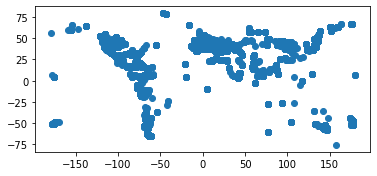

In [112]:
gpd_pbdb.plot()

`geopandas` makes it easy to save our data out as a shapefile

In [113]:
gpd_pbdb.to_file('reconstructed_pbdb_data_%sMa.shp' % reconstruction_time)

/Users/nickywright/miniconda3/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/var/folders/fm/9nwmq_gd47172_f70p3gk8nr0000gr/T/ipykernel_1917/1385639723.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gpd_pbdb.to_file('reconstructed_pbdb_data_%sMa.shp' % reconstruction_time)


### Reconstruct coastlines

In [55]:
reconstructed_coastlines = []
pygplates.reconstruct(coastlines, rotation_model, reconstructed_coastlines, reconstruction_time, export_wrap_to_dateline=True) 

### Plot


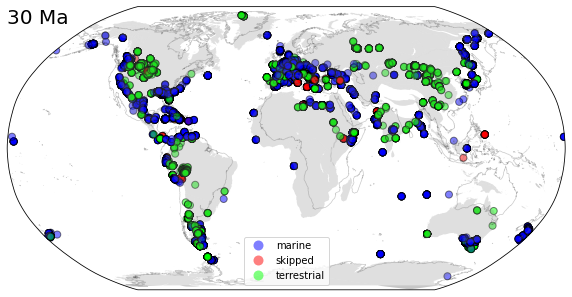

In [57]:
# --- define colours
markersize = 50
markeredgewidth = 1.5
alpha = 0.5

# plot map
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()

# present-day coastlines
ax.coastlines(color='black', linewidth=0.75, resolution='50m', alpha=0.2)

# plot reconstructed coastlines
coastlines_for_plotting = []
date_line_wrapper = pygplates.DateLineWrapper()
for polygon in reconstructed_coastlines:
    wrapped_polygons = date_line_wrapper.wrap(polygon.get_reconstructed_geometry())
    for poly in wrapped_polygons:
        coastlines_for_plotting.append(LinearRing([(p.get_longitude(), p.get_latitude()) for p in poly.get_exterior_points()]))
ax.add_geometries(coastlines_for_plotting, ccrs.PlateCarree(), facecolor='grey', alpha=0.25) 

# ---
# plot points
gpd_pbdb.plot(ax=ax, column='environment_broad', cmap='brg', alpha=alpha, edgecolor='k', 
                   markersize=markersize, transform=ccrs.PlateCarree(), legend=True)


plt.title('%s Ma' % reconstruction_time, fontsize=20, loc='left', y=0.92)
plt.show()


### Plot reconstructed fossils through time on multiple subplots

We can use functions to help simplify repetitive tasks. 

Here, we'll use a function to: 
- reconstruct paleobiology data to *X* time
- reconstruct coastlines to *X* time
- prepare our reconstructed files for plotting
- plot our coastlines and fossil points on a specified axes

In [81]:
def reconstruct_and_plot(reconstruction_time, ax):
    

    # reconstruct fossils and coastlines
    reconstruction_time = reconstruction_time

    # reconstruct pbdb data
    reconstructed_pbdb = []
    pygplates.reconstruct(pbdb_cc, rotation_model, reconstructed_pbdb, reconstruction_time)

    gpd_pbdb = create_geodataframe_from_pbdb(reconstructed_pbdb, reconstruction_time)

    reconstructed_coastlines = []
    pygplates.reconstruct(coastlines, rotation_model, reconstructed_coastlines, reconstruction_time, export_wrap_to_dateline=True)
    
    # ---- plotting parts of the function
    # define colours
    markersize = 20
    alpha = 0.2
    
    ax.set_global()
    # plot present-day coastlines
    ax.coastlines(color='black', linewidth=0.75, resolution='50m', alpha=0.2)

    # plot reconstructed coastlines
    coastlines_for_plotting = []
    date_line_wrapper = pygplates.DateLineWrapper()
    for polygon in reconstructed_coastlines:
        wrapped_polygons = date_line_wrapper.wrap(polygon.get_reconstructed_geometry())
        for poly in wrapped_polygons:
            coastlines_for_plotting.append(LinearRing([(p.get_longitude(), p.get_latitude()) for p in poly.get_exterior_points()]))
    ax.add_geometries(coastlines_for_plotting, ccrs.PlateCarree(), facecolor='grey', alpha=0.25) 

    # plot pbdb points
    gpd_pbdb.plot(ax=ax, column='environment_broad', cmap='brg', alpha=alpha, edgecolor='w',
                  markersize=markersize, transform=ccrs.PlateCarree())
    
    ax.set_title('%s Ma' % reconstruction_time, fontsize=13, loc='left', y=0.92)


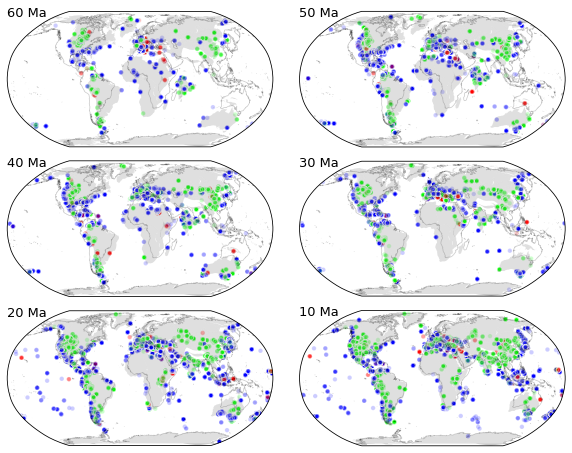

In [83]:
nrows = 3
ncols = 2

fig = plt.figure(figsize=(10, 8))

# --- first subplot
ax1 = plt.subplot(nrows, ncols, 1, projection=ccrs.Robinson())
reconstruct_and_plot(60, ax1)

# --- second subplot
ax2 = plt.subplot(nrows, ncols, 2, projection=ccrs.Robinson())
reconstruct_and_plot(50, ax2)

# --- third subplot
ax3 = plt.subplot(nrows, ncols, 3, projection=ccrs.Robinson())
reconstruct_and_plot(40, ax3)

# ---
ax4 = plt.subplot(nrows, ncols, 4, projection=ccrs.Robinson())
reconstruct_and_plot(30, ax4)

# ---
ax5 = plt.subplot(nrows, ncols, 5, projection=ccrs.Robinson())
reconstruct_and_plot(20, ax5)

# ---
ax6 = plt.subplot(nrows, ncols, 6, projection=ccrs.Robinson())
reconstruct_and_plot(10, ax6)

# set the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.show()

---

## Distribution of Cenozoic gastropods

Since we have our attributes (or columns) saved for our reconstructed fossil data, we can filter the geodataframe and just plot the location of gastropods

In [155]:
# reconstruct pbdb data
gpd_pbdb

,NAME,PLATEID1,FROMAGE,TOAGE,accepted_names,environment,environment_broad,late_interval,early_inverval,occurrence_no,geometry,reconstruction_time
0,NaN,109,33.9,28.10,Diodora,marine indet.,marine,NaN,Rupelian,68239,POINT (-72.28253 34.01306),30
1,NaN,109,33.9,28.10,Architectonica fungina,marine indet.,marine,NaN,Rupelian,68240,POINT (-72.28253 34.01306),30
2,NaN,109,33.9,28.10,Turritella,marine indet.,marine,NaN,Rupelian,68241,POINT (-72.28253 34.01306),30
3,NaN,109,33.9,28.10,Turritella,marine indet.,marine,NaN,Rupelian,68242,POINT (-72.28253 34.01306),30
4,NaN,109,33.9,28.10,Scalina,marine indet.,marine,NaN,Rupelian,68243,POINT (-72.28253 34.01306),30
...,...,...,...,...,...,...,...,...,...,...,...,...
25165,NaN,501,66.0,23.03,Dicotylophyllum reticulatum,lagoonal/restricted shallow subtidal,marine,NaN,Paleogene,1591936,POINT (69.73275 10.48136),30
25166,NaN,501,66.0,23.03,Dicotylophyllum uninervensis,lagoonal/restricted shallow subtidal,marine,NaN,Paleogene,1591937,POINT (69.73275 10.48136),30
25167,NaN,687,33.9,23.03,Dictyocha fibula,marginal marine indet.,marine,NaN,Oligocene,1591951,POINT (89.26131 8.09096),30
25168,NaN,687,33.9,23.03,Dictyocha,marginal marine indet.,marine,NaN,Oligocene,1591952,POINT (89.26131 8.09096),30


In [140]:
# Select gastropoda based on their accepted_names
gpd_pbdb_gastropod = gpd_pbdb.loc[gpd_pbdb.accepted_names == 'Gastropoda']
gpd_pbdb_gastropod

,NAME,PLATEID1,FROMAGE,TOAGE,accepted_names,environment,environment_broad,late_interval,early_inverval,occurrence_no,geometry,reconstruction_time
1674,NaN,322,33.9,23.03,Gastropoda,shallow subtidal indet.,marine,NaN,Oligocene,117527,POINT (2.78177 38.60687),30
13178,NaN,109,33.9,28.40,Gastropoda,open shallow subtidal,marine,NaN,Early Oligocene,822803,POINT (-79.55720 30.89286),30
16960,NaN,344,33.9,23.03,Gastropoda,"reef, buildup or bioherm",skipped,Chattian,Rupelian,1199974,POINT (1.95608 41.75997),30
19670,NaN,503,33.9,28.40,Gastropoda,coastal indet.,marine,NaN,Early Oligocene,1317544,POINT (44.42411 8.87339),30
22563,NaN,101,66.0,23.03,Gastropoda,marine indet.,marine,NaN,Paleogene,1406001,POINT (-114.63000 37.27056),30
23563,NaN,2041,33.9,28.10,Gastropoda,marine indet.,marine,NaN,Rupelian,1468237,POINT (-74.38645 3.53628),30
24567,NaN,3071,33.9,28.10,Gastropoda,"reef, buildup or bioherm",skipped,NaN,Rupelian,1527433,POINT (7.89270 37.40245),30


In [156]:
# calculate the average age, based on their appearance (FROMAGE) and disappearance age (TOAGE)
gpd_pbdb_gastropod['average_age'] = (gpd_pbdb_gastropod.FROMAGE + gpd_pbdb_gastropod.TOAGE)/2

/Users/nickywright/miniconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [157]:
gpd_pbdb_gastropod

,NAME,PLATEID1,FROMAGE,TOAGE,accepted_names,environment,environment_broad,late_interval,early_inverval,occurrence_no,geometry,reconstruction_time,average_age
1674,NaN,322,33.9,23.03,Gastropoda,shallow subtidal indet.,marine,NaN,Oligocene,117527,POINT (2.78177 38.60687),30,28.465
13178,NaN,109,33.9,28.40,Gastropoda,open shallow subtidal,marine,NaN,Early Oligocene,822803,POINT (-79.55720 30.89286),30,31.150
16960,NaN,344,33.9,23.03,Gastropoda,"reef, buildup or bioherm",skipped,Chattian,Rupelian,1199974,POINT (1.95608 41.75997),30,28.465
19670,NaN,503,33.9,28.40,Gastropoda,coastal indet.,marine,NaN,Early Oligocene,1317544,POINT (44.42411 8.87339),30,31.150
22563,NaN,101,66.0,23.03,Gastropoda,marine indet.,marine,NaN,Paleogene,1406001,POINT (-114.63000 37.27056),30,44.515
23563,NaN,2041,33.9,28.10,Gastropoda,marine indet.,marine,NaN,Rupelian,1468237,POINT (-74.38645 3.53628),30,31.000
24567,NaN,3071,33.9,28.10,Gastropoda,"reef, buildup or bioherm",skipped,NaN,Rupelian,1527433,POINT (7.89270 37.40245),30,31.000


Plot

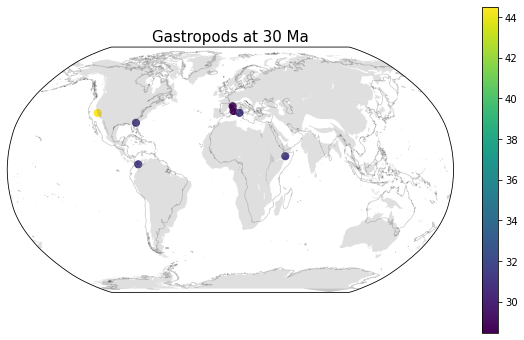

In [158]:
# --- define colours
markersize = 50

# plot map
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()

# present-day coastlines
ax.coastlines(color='black', linewidth=0.75, resolution='50m', alpha=0.2)


# plot reconstructed coastlines
coastlines_for_plotting = []
date_line_wrapper = pygplates.DateLineWrapper()
for polygon in reconstructed_coastlines:
    wrapped_polygons = date_line_wrapper.wrap(polygon.get_reconstructed_geometry())
    for poly in wrapped_polygons:
        coastlines_for_plotting.append(LinearRing([(p.get_longitude(), p.get_latitude()) for p in poly.get_exterior_points()]))
ax.add_geometries(coastlines_for_plotting, ccrs.PlateCarree(), facecolor='grey', alpha=0.25) 

# ---
# plot pbdb points, and colour by average age column
gpd_pbdb_gastropod.plot(ax=ax, column='average_age', markersize=markersize, transform=ccrs.PlateCarree(), legend=True)

plt.title('Gastropods at %s Ma' % reconstruction_time, fontsize=15)
plt.show()
